In [1]:
import numpy as np
import cv2  # OpenCVライブラリ

import matplotlib.pyplot as plt 
%matplotlib inline

import torch

from utils.ssd_model import DataTransform

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Inference with Test time augumentation

## Test with flips.
the predictions are merged before the nms processing.

load models and test inference

In [2]:
from utils.ssd_model import SSD

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

# SSD300の設定
ssd_cfg = {
    'num_classes': 21,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSDネットワークモデル
net = SSD(phase="train", cfg=ssd_cfg)

# SSDの学習済みの重みを設定
net_weights = torch.load('./weights/ssd300_200.pth', map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

net = net.to(device)

cuda:0
./horse/uma-san2.jpg


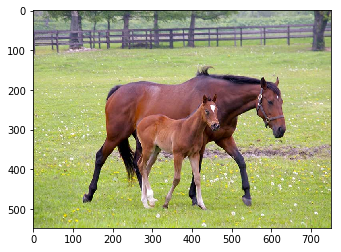

(300, 300, 3)
./horse/sample_horse.jpg


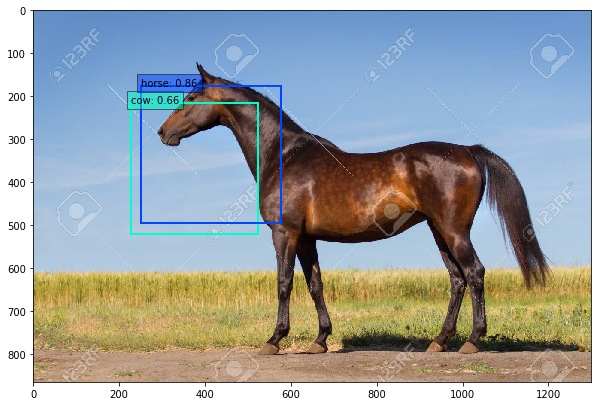

(300, 300, 3)
./horse/20101210_an01_012.jpg


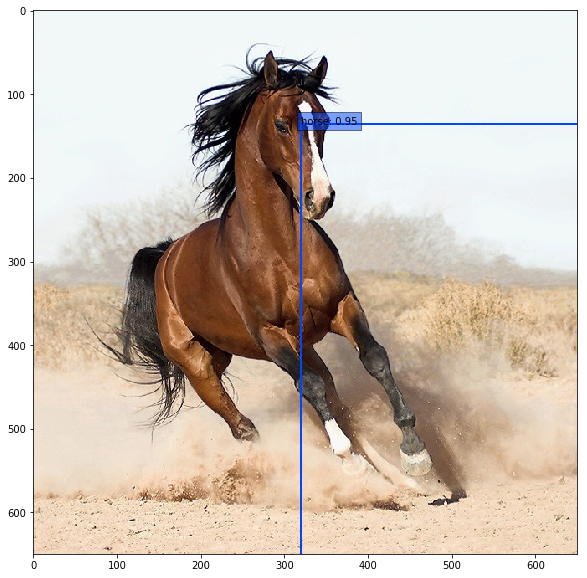

(300, 300, 3)
./horse/pic_1.jpg


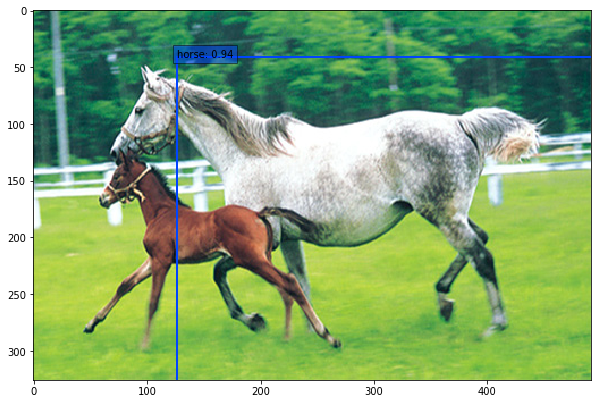

(300, 300, 3)
./horse/horses-14148.jpg


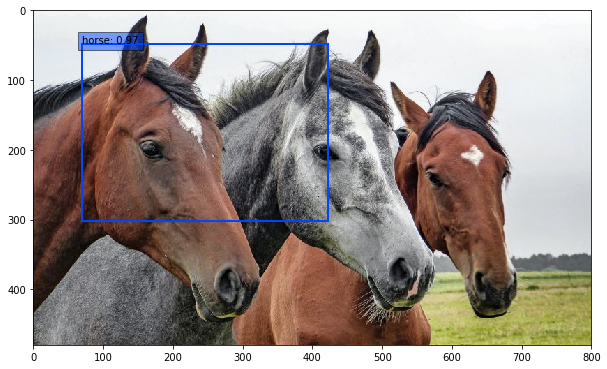

(300, 300, 3)
./horse/heritage_046_main1.jpg


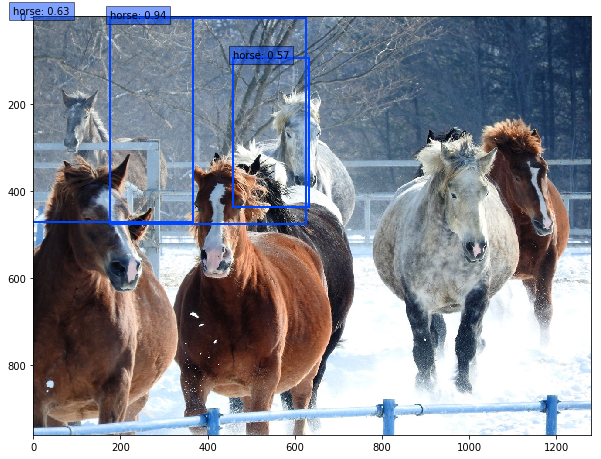

(300, 300, 3)
./horse/images.jpg


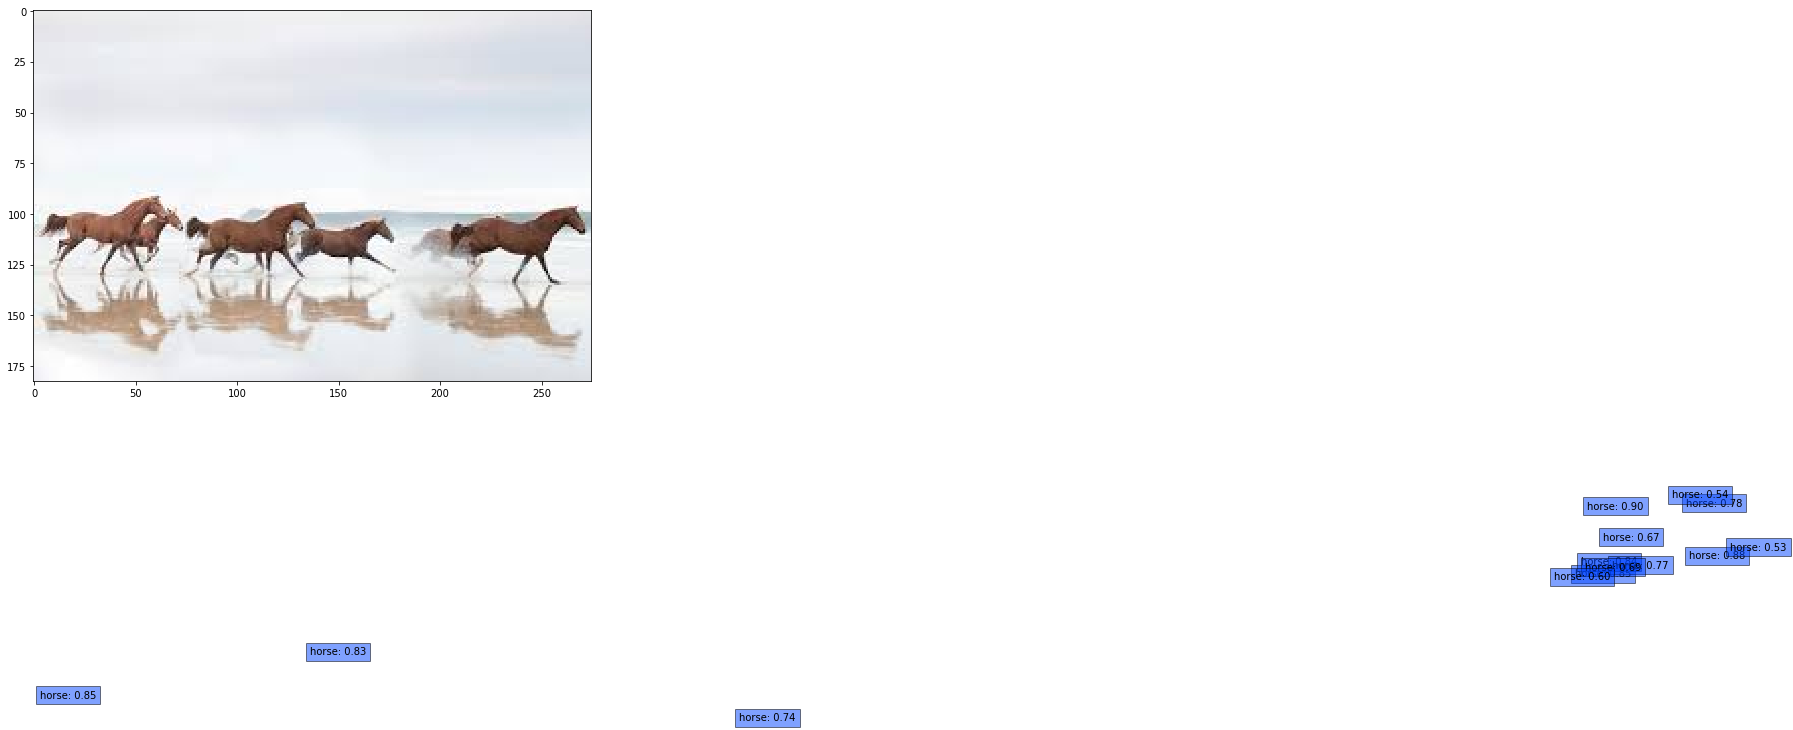

(300, 300, 3)
./horse/sample.JPG


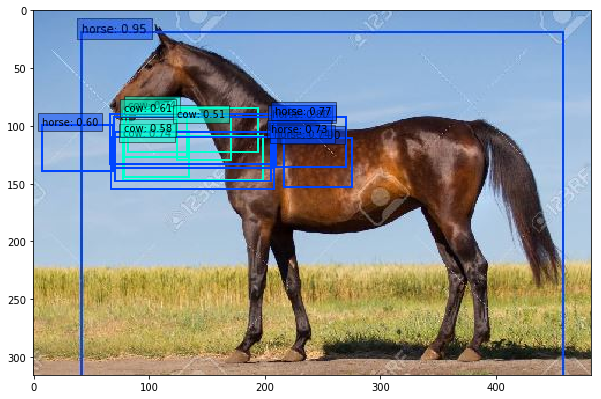

(300, 300, 3)


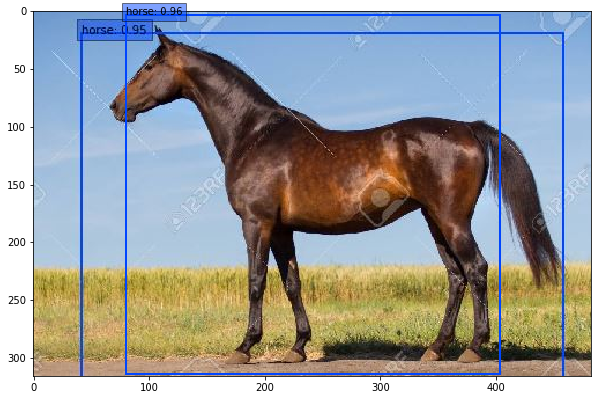

In [3]:
# 1. 画像読み込み
#image_file_path = "../../VOCdevkit/VOC2007/JPEGImages/009961.jpg"
image_file_path = "./horse/*"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import glob

# for TTA
from utils.ssd import Detect_Flip
Det = Detect_Flip()
Det = Det.to(device).eval()

# for vis
from utils.ssd_predict_show import SSDPredictShowFlip
ssd = SSDPredictShowFlip(eval_categories=voc_classes, net=net, device=device).to(device)

for imp in glob.glob(image_file_path):
    print(imp)
    img = cv2.imread(imp)  # [高さ][幅][色BGR]
    height, width, channels = img.shape  # 画像のサイズを取得

    # 2. 元画像の表示
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

    # 3. 前処理クラスの作成
    color_mean = (104, 117, 123)  # (BGR)の色の平均値
    input_size = 300  # 画像のinputサイズを300×300にする
    transform = DataTransform(input_size, color_mean)

    # 4. 前処理
    phase = "val"
    img_transformed, boxes, labels = transform(
        img, phase, "", "")  # アノテーションはないので、""にする
    img_flip = img_transformed[:, :, ::-1]
    print(img_transformed.shape)
    
    x = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)
    x_flip = torch.from_numpy(img_flip[:, :, (2, 1, 0)]).permute(2, 0, 1)

    # 5. SSDで予測
    net.eval()  # ネットワークを推論モードへ
    x = x.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 300, 300])
    with torch.no_grad():
        detections = net(x.to(device))
    
    # 6. 反転した画像で推論
    x_flip = x_flip.unsqueeze(0)
    with torch.no_grad():
        detections_flip = net(x_flip.to(device))
    
    # detectionsは
    # locのサイズは、torch.Size([batch_num, 8732, 4])
    # confのサイズは、torch.Size([batch_num, 8732, 21])
    
    # 7. NMS等を実行し推論結果を得る
    #output = Det(detections[0], detections[1], detections_flip[0], detections_flip[1], detections[2].to(device))
    
    # 8. 結果を可視化！
    ssd.show(imp, data_confidence_level=0.5)

./imgs/24071_20180420GENE01.jpg


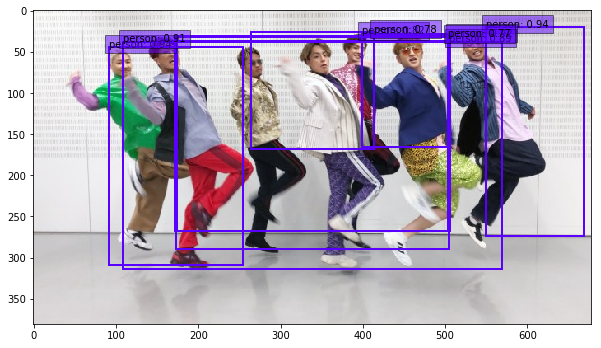

./imgs/sample2.JPG


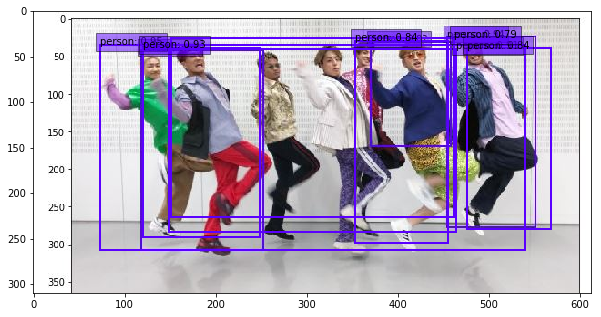

./imgs/a.jpg


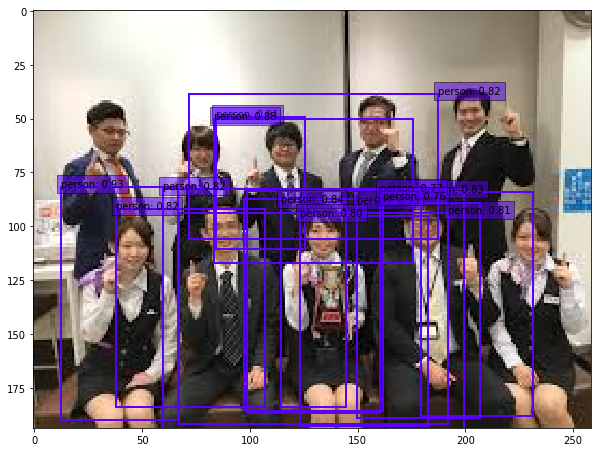

./imgs/syuugou01.jpg


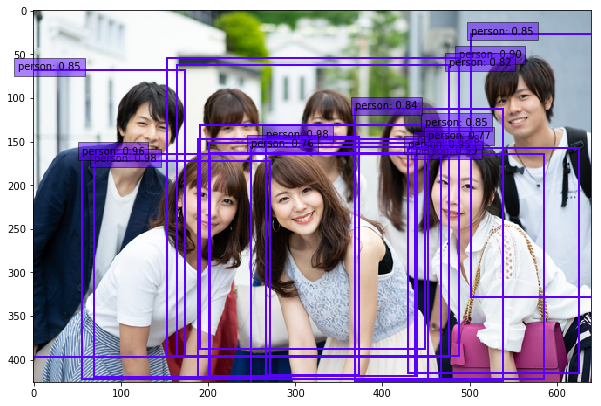

./imgs/EZ6I1552_-720x480.jpg


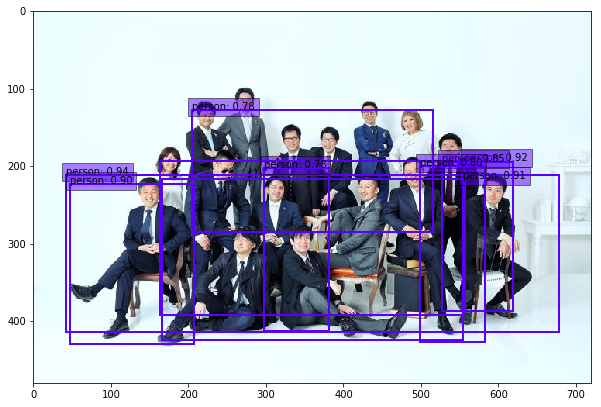

./imgs/main.jpg


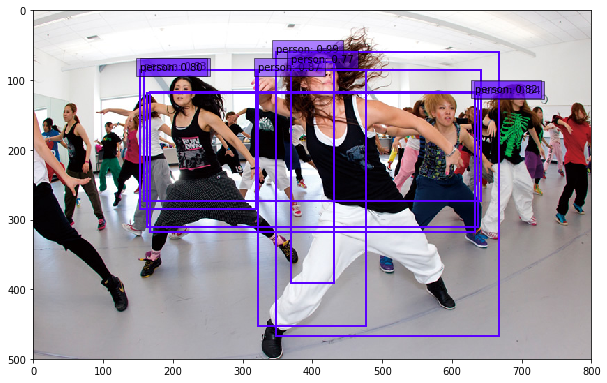

./imgs/b.jpg


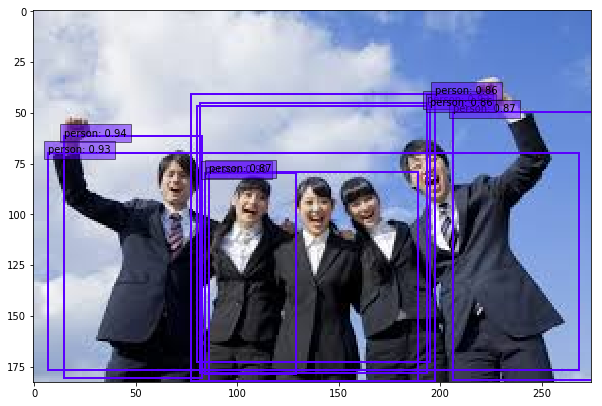

./imgs/img_2cff4a19be74dcd1bc1d54855bd3ec4d207066.jpg


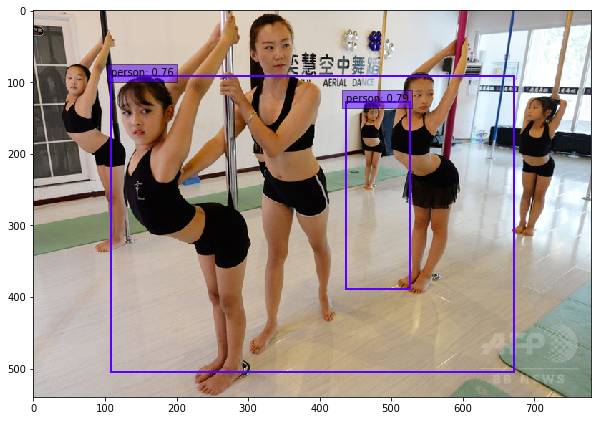

./imgs/TWICE35.jpg


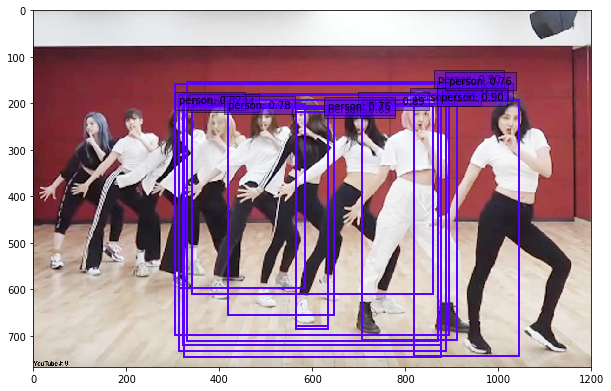

./imgs/AS20190821003362_commL.jpg


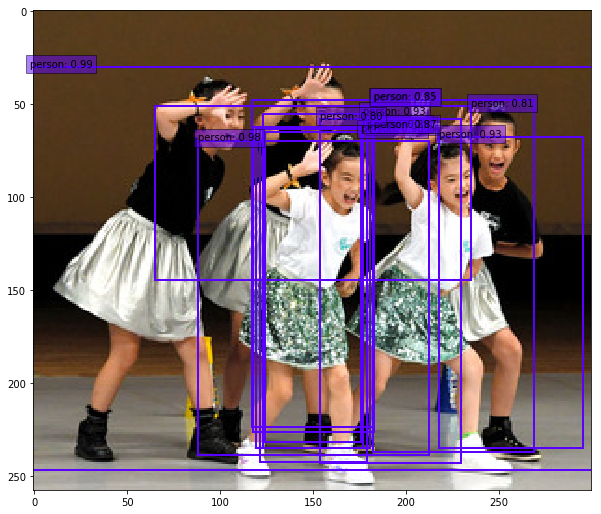

./imgs/1.png


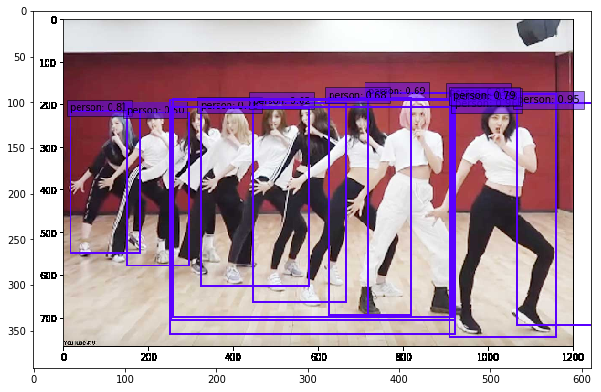

In [6]:
image_file_path = "./imgs/*"
for imp in glob.glob(image_file_path):
    print(imp)
    img = cv2.imread(imp)  # [高さ][幅][色BGR]
    height, width, channels = img.shape  # 画像のサイズを取得
    
    ssd.show(imp, data_confidence_level=0.5)
    plt.show()